# Fashion MNIST 분류기
- pytorch로 구현

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch

import torchvision.transforms as T
import torchvision
import torchvision.utils as vutils
from torchsummary import summary

from sklearn.metrics import accuracy_score

## data load

In [2]:
transform = T.Compose([
    T.ToTensor(),
])

In [3]:
download_root = './FASHION_MNIST_DATASET'

train_dataset = torchvision.datasets.FashionMNIST(download_root, transform=transform, train=True, download=True)
test_dataset = torchvision.datasets.FashionMNIST(download_root, transform=transform, train=False, download=True)

In [4]:
# 데이터 셋을 학습 데이터 셋과 검증 데이터 셋으로 분리합니다.
total_size = len(train_dataset)
train_num, valid_num = int(total_size * 0.8), int(total_size * 0.2) # 8 : 2 = train : valid
print("Train dataset 개수 : ", train_num)
print("Validation dataset 개수 : ", valid_num)
train_dataset,valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num]) # train - valid set 나누기

Train dataset 개수 :  48000
Validation dataset 개수 :  12000


In [5]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
for images, labels in train_dataloader:
    print(images.shape)
    print(labels)
    break

torch.Size([32, 1, 28, 28])
tensor([7, 7, 1, 5, 6, 4, 2, 6, 1, 7, 8, 5, 6, 9, 2, 4, 8, 1, 1, 9, 7, 0, 3, 1,
        7, 5, 6, 6, 1, 1, 1, 2])


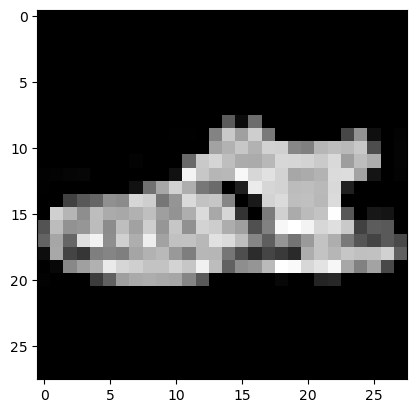

In [17]:
plt.imshow(images[3].squeeze().numpy(), cmap='gray')

## Model 구현

In [41]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )

        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block4 = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(7*7*128, 1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(1024, 564),
            torch.nn.ReLU(True),
            torch.nn.Linear(564, 10),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        output = self.block4(x)

        return output
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [42]:
model = CNN()

In [43]:
print(summary(model, input_size=((1, 28, 28))))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 16, 28, 28]           2,320
              ReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         MaxPool2d-7           [-1, 16, 28, 28]               0
            Conv2d-8           [-1, 32, 28, 28]           4,640
              ReLU-9           [-1, 32, 28, 28]               0
      BatchNorm2d-10           [-1, 32, 28, 28]              64
           Conv2d-11           [-1, 32, 28, 28]           9,248
             ReLU-12           [-1, 32, 28, 28]               0
      BatchNorm2d-13           [-1, 32, 28, 28]              64
        MaxPool2d-14           [-1, 32,

In [44]:
model.count_parameters()

7356790

## Model 학습

In [45]:
def training(model, train_dataloader, train_dataset, optimizer, criterion):
    model.train()

    tbar = tqdm.tqdm(train_dataloader)

    for images, labels in tbar:
        print(labels)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return model

In [46]:
model=CNN()

In [47]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = training(model, train_dataloader, train_dataset, optimizer, criterion)

  0%|          | 0/1500 [00:00<?, ?it/s]

tensor([2, 5, 7, 5, 1, 2, 1, 4, 9, 0, 6, 8, 0, 5, 8, 6, 9, 5, 9, 6, 9, 6, 0, 4,
        6, 1, 6, 4, 5, 9, 0, 3])
tensor([7, 5, 9, 9, 7, 3, 7, 3, 2, 9, 8, 8, 1, 1, 5, 8, 7, 3, 1, 6, 3, 5, 9, 9,
        5, 9, 5, 9, 4, 6, 3, 5])
tensor([9, 1, 7, 5, 2, 5, 8, 8, 9, 8, 0, 2, 1, 3, 7, 8, 0, 8, 7, 2, 0, 5, 8, 7,
        6, 3, 5, 6, 1, 8, 3, 1])
tensor([3, 2, 4, 3, 7, 0, 1, 1, 3, 4, 8, 0, 3, 2, 0, 1, 4, 8, 6, 6, 6, 8, 1, 4,
        2, 2, 7, 3, 2, 2, 5, 3])
tensor([5, 4, 5, 5, 7, 2, 2, 3, 8, 4, 0, 6, 3, 3, 9, 4, 4, 2, 1, 5, 4, 3, 9, 3,
        7, 6, 3, 3, 3, 2, 4, 6])
tensor([2, 8, 6, 9, 4, 9, 0, 0, 5, 4, 0, 8, 9, 0, 4, 0, 7, 8, 3, 6, 6, 2, 9, 7,
        9, 6, 6, 1, 2, 9, 5, 9])
tensor([1, 7, 5, 7, 1, 4, 8, 6, 7, 0, 3, 5, 3, 9, 4, 8, 7, 1, 5, 2, 3, 5, 3, 8,
        7, 9, 9, 1, 8, 3, 3, 5])
tensor([3, 1, 0, 3, 8, 4, 7, 6, 5, 7, 8, 2, 3, 5, 9, 4, 7, 5, 8, 4, 9, 9, 9, 1,
        6, 8, 4, 7, 4, 6, 8, 5])
tensor([8, 4, 2, 5, 3, 4, 8, 9, 7, 6, 3, 5, 9, 0, 8, 7, 2, 0, 3, 0, 2, 8, 9, 1,
        9, 4, 0,

## Model 테스트

In [35]:
model.eval()
total_labels = []
total_preds = []
with torch.no_grad():
    tbar = tqdm.tqdm(test_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs.data, 1)

        
        total_preds.extend(predicted.tolist())
        total_labels.extend(labels.tolist())

'''
total_preds = np.array(total_preds)
total_labels = np.array(total_labels)
custom_cnn_acc = accuracy_score(total_labels, total_preds) # 정확도 계산
print("Custom CNN model accuracy : ", custom_cnn_acc)
'''

  0%|          | 0/313 [00:00<?, ?it/s]

'\ntotal_preds = np.array(total_preds)\ntotal_labels = np.array(total_labels)\ncustom_cnn_acc = accuracy_score(total_labels, total_preds) # 정확도 계산\nprint("Custom CNN model accuracy : ", custom_cnn_acc)\n'

In [36]:
total_preds

[9,
 1,
 1,
 1,
 9,
 1,
 1,
 9,
 1,
 9,
 9,
 9,
 9,
 1,
 1,
 1,
 9,
 9,
 9,
 1,
 9,
 9,
 9,
 9,
 1,
 9,
 1,
 1,
 9,
 1,
 9,
 9,
 1,
 1,
 9,
 0,
 9,
 9,
 9,
 9,
 1,
 1,
 1,
 9,
 1,
 9,
 9,
 1,
 9,
 9,
 0,
 9,
 9,
 0,
 9,
 9,
 9,
 9,
 9,
 1,
 9,
 9,
 9,
 9,
 1,
 1,
 1,
 1,
 9,
 9,
 9,
 1,
 9,
 1,
 1,
 1,
 1,
 1,
 9,
 9,
 1,
 9,
 9,
 9,
 9,
 1,
 1,
 1,
 1,
 9,
 9,
 1,
 1,
 9,
 1,
 9,
 9,
 1,
 1,
 1,
 1,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 0,
 9,
 0,
 9,
 9,
 9,
 9,
 0,
 0,
 9,
 9,
 1,
 0,
 9,
 1,
 1,
 1,
 1,
 1,
 9,
 1,
 9,
 9,
 9,
 1,
 9,
 9,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 9,
 9,
 1,
 1,
 9,
 0,
 1,
 9,
 9,
 1,
 9,
 9,
 1,
 9,
 1,
 9,
 1,
 9,
 9,
 9,
 1,
 9,
 9,
 1,
 9,
 9,
 1,
 0,
 9,
 1,
 0,
 9,
 1,
 0,
 9,
 9,
 9,
 1,
 1,
 9,
 1,
 9,
 1,
 9,
 1,
 9,
 9,
 1,
 1,
 1,
 1,
 0,
 9,
 9,
 0,
 1,
 0,
 9,
 9,
 1,
 1,
 1,
 9,
 9,
 1,
 1,
 1,
 1,
 9,
 1,
 9,
 9,
 9,
 0,
 9,
 9,
 9,
 1,
 9,
 0,
 9,
 9,
 9,
 9,
 9,
 0,
 9,
 1,
 1,
 9,
 9,
 9,
 9,
 1,
 1,
 9,
 9,
 1,
 9,
 1,
